## Download a pretrained model
Torchvision has a number of proven models available through <a href='https://pytorch.org/docs/stable/torchvision/models.html#classification'><tt><strong>torchvision.models</strong></tt></a>:
<ul>
<li><a href="https://arxiv.org/abs/1404.5997">AlexNet</a></li>
<li><a href="https://arxiv.org/abs/1409.1556">VGG</a></li>
<li><a href="https://arxiv.org/abs/1512.03385">ResNet</a></li>
<li><a href="https://arxiv.org/abs/1602.07360">SqueezeNet</a></li>
<li><a href="https://arxiv.org/abs/1608.06993">DenseNet</a></li>
<li><a href="https://arxiv.org/abs/1512.00567">Inception</a></li>
<li><a href="https://arxiv.org/abs/1409.4842">GoogLeNet</a></li>
<li><a href="https://arxiv.org/abs/1807.11164">ShuffleNet</a></li>
<li><a href="https://arxiv.org/abs/1801.04381">MobileNet</a></li>
<li><a href="https://arxiv.org/abs/1611.05431">ResNeXt</a></li>
</ul>
These have all been trained on the <a href='http://www.image-net.org/'>ImageNet</a> database of images. Our only task is to reduce the output of the fully connected layers from (typically) 1000 categories to just 2.

To access the models, you can construct a model with random weights by calling its constructor:<br>
<pre>resnet18 = models.resnet18()</pre>
You can also obtain a pre-trained model by passing pretrained=True:<br>
<pre>resnet18 = models.resnet18(pretrained=True)</pre>
All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

Feel free to investigate the different models available. Each one will be downloaded to a cache directory the first time they're accessed - from then on they'll be available locally.

For its simplicity and effectiveness, we'll use AlexNet:

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [5]:
AlexNetmodel = models.alexnet(pretrained=True)
AlexNetmodel

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /Users/arissa/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|████████████████████████████████████████| 233M/233M [00:03<00:00, 74.9MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

<div class="alert alert-info">This model uses <a href='https://pytorch.org/docs/master/nn.html#torch.nn.AdaptiveAvgPool2d'><tt><strong>torch.nn.AdaptiveAvgPool2d(<em>output_size</em>)</strong></tt></a> to convert the large matrix coming out of the convolutional layers to a (6x6)x256 matrix being fed into the fully connected layers.</div>

## Freeze feature parameters
We want to freeze the pre-trained weights & biases. We set <tt>.requires_grad</tt> to False so we don't backprop through them.

In [10]:
for param in AlexNetmodel.parameters():
    param.requires_grad = False

## Modify the classifier
Next we need to modify the fully connected layers to produce a binary output. The section is labeled "classifier" in the AlexNet model.<br>
Note that when we assign new layers, their parameters default to <tt>.requires_grad=True</tt>.

In [13]:
torch.manual_seed(42)
AlexNetmodel.classifier = nn.Sequential(nn.Linear(9216, 1024),
                                 nn.ReLU(),
                                 nn.Dropout(0.4),
                                 nn.Linear(1024, 2),
                                 nn.LogSoftmax(dim=1))
AlexNetmodel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, 

In [17]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

In [19]:
# These are the TRAINABLE parameters:
count_parameters(AlexNetmodel)

 9437184
    1024
    2048
       2
________
 9440258


In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(AlexNetmodel.classifier.parameters(), lr=0.001)

In [27]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

In [29]:
root = '/Users/arissa/Desktop/CATS_DOGS'

train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform=test_transform)

torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)

class_names = train_data.classes

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

['CAT', 'DOG']
Training images available: 18743
Testing images available:  6251


In [30]:
import time
start_time = time.time()

epochs = 1

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = AlexNetmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = AlexNetmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:  200 [  2000/8000]  loss: 0.05920790  accuracy:  89.100%
epoch:  0  batch:  400 [  4000/8000]  loss: 0.30264765  accuracy:  91.500%
epoch:  0  batch:  600 [  6000/8000]  loss: 0.06425178  accuracy:  92.450%
epoch:  0  batch:  800 [  8000/8000]  loss: 0.01189719  accuracy:  92.750%

Duration: 186 seconds


In [32]:
print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/3000:.3f}%')

[tensor(2824)]
Test accuracy: 94.133%


Label: [0 0 1 1 0 1 0 0 0 0]
Class: CAT CAT DOG DOG CAT DOG CAT CAT CAT CAT


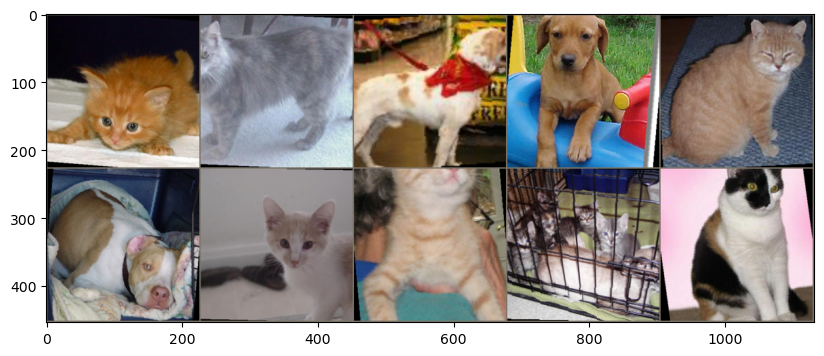

In [41]:
# Grab the first batch of 10 images
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=5)  # the default nrow is 8

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));